In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from itertools import product

import src.training as training
import src.models as models

from importlib import reload
reload(training)
reload(models)

device = 'cuda'

In [2]:
def load_training_data(batch_size, n_tasks, n_samples, seed):

    # seed the random number generator
    rng = np.random.RandomState(seed)
    task_inds = rng.choice(1000, n_tasks+1, replace=False)
    sample_inds = rng.choice(5000, n_samples, replace=False)
    # sort the indices
    task_inds.sort()

    # Load the data and construct a dataloader
    filepath = 'data/1000tasks_5000samples_14seed.h5'
    with h5.File(filepath, 'r') as f:
        X_train = f['X_train'][task_inds]
        y_train = f['y_train'][task_inds]
        X_val = f['X_train'][task_inds[-1]]
        y_val = f['y_train'][task_inds[-1]]

    X_train = X_train[:,sample_inds,:]
    y_train = y_train[:,sample_inds,:]

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)

    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_val, y_val, train_size=100, test_size=4000, random_state=14)

    X_val_train = torch.tensor(X_val_train, dtype=torch.float32).to(device)
    y_val_train = torch.tensor(y_val_train, dtype=torch.float32).to(device)
    X_val_test = torch.tensor(X_val_test, dtype=torch.float32).to(device)
    y_val_test = torch.tensor(y_val_test, dtype=torch.float32).to(device)

    # Scale
    y_val_train = torch.log(y_val_train)
    y_val_test = torch.log(y_val_test)

    ScalerX = training.TorchStandardScaler()
    ScalerY = training.TorchStandardScaler()

    X_val_train = ScalerX.fit_transform(X_val_train)
    y_val_train = ScalerY.fit_transform(y_val_train)
    X_val_test = ScalerX.transform(X_val_test)
    y_val_test = ScalerY.transform(y_val_test)

    return train_dataloader, X_val_train, y_val_train, X_val_test, y_val_test

def train_model(train_dataloader, X_val_train, y_val_train, X_val_test, y_val_test, metalearner):

    # Train the model
    converged = False

    # Lists to store the losses
    meta_losses = []
    val_losses = []

    # Initialise convergence criteria
    epoch = 0
    best_val_loss = np.inf
    strike = 0

    # Loop until convergence
    while not converged:
        epoch_loss = 0.0  # Accumulate loss for reporting purposes
        batch_count = 0   # Keep track of the number of batches
        metalearner.model.train()
        # Iterate through all batches in the dataloader
        for x_batch, y_batch in train_dataloader:
            x_batch = x_batch.to(metalearner.device)  # Move to GPU if available
            y_batch = y_batch.to(metalearner.device)

            # Take logarithm of y_batch
            y_batch = torch.log(y_batch)

            # Split the data into support and query sets
            x_spt, y_spt, x_qry, y_qry = training.support_query_split(
                x_batch, y_batch, spt_frac=0.6
            )

            # Perform one meta update step across the batch, scaling applied internally
            meta_loss = metalearner.meta_train(
                x_spt, y_spt, x_qry, y_qry, inner_steps=5
            )
            
            # Accumulate meta-loss for epoch statistics
            epoch_loss += meta_loss
            batch_count += 1

        # Compute average meta-loss for the epoch
        avg_meta_loss = epoch_loss / batch_count
        meta_losses.append(avg_meta_loss)
        epoch += 1

        # fine-tune the model on the validation set
        task_weights, _ = metalearner.finetune(X_val_train, y_val_train, adapt_steps=32, use_new_adam=True)

        # Evaluate the model on the test set
        metalearner.model.eval()
        with torch.no_grad():
            y_pred = metalearner.model(X_val_test, params=task_weights)
            new_val_loss = metalearner.loss_fn(y_pred, y_val_test).item()
            val_losses.append(new_val_loss)

        if best_val_loss - new_val_loss < 1e-4:
            strike += 1
            if strike >= 20:
                converged = True
                print('Validation loss has not improved for 20 epochs. Stopping training.')
        else:
            strike = 0

        # Update the best validation loss if necessary
        if new_val_loss < best_val_loss:
            best_val_loss = new_val_loss

        print(f'Epoch {epoch} - Val Loss: {new_val_loss} - Strike: {strike}')

    return meta_losses, val_losses
    
def load_test_data(train_size):

    filepath = 'mcmc_dndz_nsamples=20000.h5'
    with h5.File(filepath, 'r') as f:
        X = f['hypercube'][:]
        y = f['c_ells'][:]

    # Take log of y
    y_log = np.log(y)

    # Split into test training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, train_size=train_size, random_state=14)

    # Send data to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    #Scale the data
    ScalerX = training.TorchStandardScaler()
    X_train = ScalerX.fit_transform(X_train)
    X_test = ScalerX.transform(X_test)

    ScalerY = training.TorchStandardScaler()
    y_train = ScalerY.fit_transform(y_train)

    # test on the test set in batches
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=2048, shuffle=False)

    return X_train, y_train, test_loader, ScalerY

def test_model(metalearner, adapt_steps, X_train, y_train, test_loader, ScalerY):

    # Perform finetuning
    task_weights, _ = metalearner.finetune(X_train, y_train, adapt_steps=adapt_steps)

    ############# MAML TRAINING #############
    # Construct empty tensor to store 
    metalearner.model.eval()
    y_pred = torch.tensor([]).to(device)
    y_test = torch.tensor([]).to(device)
    for X_batch, y_batch in test_loader:
        with torch.no_grad(): # don't compute gradients during inference
            y_pred_batch = metalearner.model(X_batch, params=task_weights)
            y_pred = torch.cat((y_pred, y_pred_batch), dim=0)
            y_test = torch.cat((y_test, y_batch), dim=0)

    # Inverse transform the data
    y_pred = ScalerY.inverse_transform(y_pred)

    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Exponentiate the data
    y_pred_np = np.exp(y_pred_np)
    y_test_np = np.exp(y_test_np)

    # Compute mean absolute percentage error along the test set
    apes = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
    ell_ape = np.mean(apes, axis=1)
    maml_mape = np.mean(np.mean(apes, axis=0))
    maml_xape = np.mean(np.max(apes, axis=0))
    maml_frate = len(ell_ape[ell_ape > 5]) / len(ell_ape)

    return maml_mape, maml_xape, maml_frate

In [3]:
# construct dict of training parameters
training_params = {
    'batch_size' : [2, 5, 10, 20],
    'n_tasks' : [20, 60, 100, 200],
    'n_samples' : [100, 500, 1000, 2000],
}

# construct list parameter combinations
param_combinations = list(product(*training_params.values()))
keys = training_params.keys()

# Define lists to store results
mape_values = []
xape_values = []
frate_values = []

# Ensure reproducibility between runs
torch.manual_seed(14)
torch.cuda.manual_seed(14)

# loop over all parameter combinations
count = 1
for comb in param_combinations:
    # Clear the output
    clear_output(wait=True)

    # Map the parameter combination to the training parameters
    params = dict(zip(keys, comb))
    print(f'Combination {count}/{len(param_combinations)}: {params}')
    if count > 1:
        print(f'Previous model results: {maml_mape}%, {maml_xape}%, {maml_frate}')

    # Load the training data
    train_dataloader, X_val_train, y_val_train, X_val_test, y_val_test = load_training_data(
        params['batch_size'], params['n_tasks'], params['n_samples'], seed=14
    )

    # Define the model 
    model = models.FastWeightCNN(
        input_size=10,
        latent_dim=(16,16),
        output_size=750,
        dropout_rate=0.2
    )

    # Initialise a MetaLearner
    metalearner = training.MetaLearner(
        model=model,
        outer_lr=0.01,
        inner_lr=0.001,
        loss_fn=torch.nn.MSELoss,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8,
        seed=14,
        device=device
    )

    # Train the model
    meta_losses, val_losses = train_model(
        train_dataloader, X_val_train, y_val_train, X_val_test, y_val_test, metalearner
    )

    # Load the test data
    X_train, y_train, test_loader, ScalerY = load_test_data(train_size=100)

    # Test the model
    maml_mape, maml_xape, maml_frate = test_model(
        metalearner, 32, X_train, y_train, test_loader, ScalerY
    )

    # Append the results
    mape_values.append(maml_mape)
    xape_values.append(maml_xape)
    frate_values.append(maml_frate)

    count += 1

# Save the results
fname = 'maml_data_volume_results.h5'
with h5.File(fname, 'w') as f:
    f.create_dataset('mape_values', data=mape_values)
    f.create_dataset('xape_values', data=xape_values)
    f.create_dataset('frate_values', data=frate_values)
    f.create_dataset('param_combinations', data=param_combinations)

Combination 64/64: {'batch_size': 20, 'n_tasks': 200, 'n_samples': 2000}
Previous model results: 5.573432922363281%, 96.8367691040039%, 0.34050251256281405
Epoch 1 - Val Loss: 0.07538488507270813 - Strike: 0
Epoch 2 - Val Loss: 0.060079656541347504 - Strike: 0
Epoch 3 - Val Loss: 0.03190475329756737 - Strike: 0
Epoch 4 - Val Loss: 0.024301018565893173 - Strike: 0
Epoch 5 - Val Loss: 0.020811688154935837 - Strike: 0
Epoch 6 - Val Loss: 0.017179900780320168 - Strike: 0
Epoch 7 - Val Loss: 0.012564768083393574 - Strike: 0
Epoch 8 - Val Loss: 0.017061956226825714 - Strike: 1
Epoch 9 - Val Loss: 0.013887462206184864 - Strike: 2
Epoch 10 - Val Loss: 0.009647155180573463 - Strike: 0
Epoch 11 - Val Loss: 0.011737290769815445 - Strike: 1
Epoch 12 - Val Loss: 0.0069603933952748775 - Strike: 0
Epoch 13 - Val Loss: 0.006632386706769466 - Strike: 0
Epoch 14 - Val Loss: 0.006381081882864237 - Strike: 0
Epoch 15 - Val Loss: 0.009153599850833416 - Strike: 1
Epoch 16 - Val Loss: 0.006095888093113899 - 

In [30]:
# Load the data from the file
fname = 'maml_data_volume_results.h5'
with h5.File(fname, 'r') as f:
    # get keys
    keys = list(f.keys())
    print(keys)

['frate_values', 'mape_values', 'param_combinations', 'xape_values']


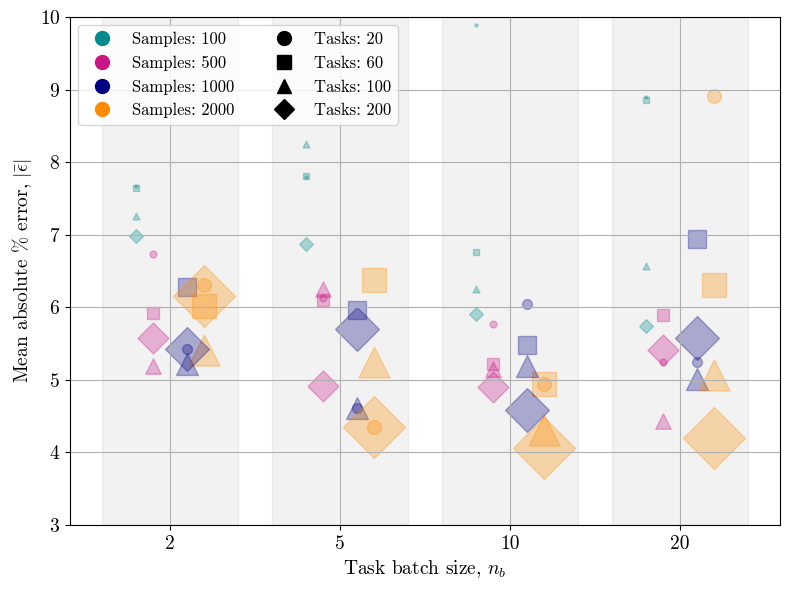

In [39]:
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

# Define distinct colors for the number of samples
sample_colors = {
    100: 'darkcyan',
    500: 'mediumvioletred',
    1000: 'navy',
    2000: 'darkorange'
}

offsets = {
    100: -0.2,
    500: -0.1,
    1000: 0.1,
    2000: 0.2
}

# Define distinct marker styles for the number of tasks
task_markers = {
    20: 'o',    # Circle
    60: 's',    # Square
    100: '^',   # Triangle
    200: 'D'    # Diamond
}

# Load the data from the file
fname = 'maml_data_volume_results.h5'
with h5.File(fname, 'r') as f:
    mape_values = np.array(f['mape_values'])
    param_combinations = np.array(f['param_combinations'])

# Extract parameter values
batch_sizes = param_combinations[:, 0]  # First parameter: batch_size
n_tasks = param_combinations[:, 1]     # Second parameter: n_tasks
n_samples = param_combinations[:, 2]   # Third parameter: n_samples

# Map batch sizes to evenly spaced positions
unique_batch_sizes = sorted(set(batch_sizes))  # Get unique batch sizes
batch_size_positions = {batch_size: idx for idx, batch_size in enumerate(unique_batch_sizes)}  # Map batch sizes to integers
mapped_batch_sizes = [batch_size_positions[bs] for bs in batch_sizes]  # Map each batch size in the data

# Create the scatter plot
plt.figure(figsize=(8, 6))

# Add shaded backgrounds for each batch size
for idx in range(len(unique_batch_sizes)):
    plt.axvspan(idx - 0.4, idx + 0.4, color='gray', alpha=0.1)

for mapped_bs, batch_size, n_task, n_sample, mape in zip(mapped_batch_sizes, batch_sizes, n_tasks, n_samples, mape_values):
    plt.scatter(
        mapped_bs+offsets[n_sample], 
        mape,
        s=(n_task*n_sample)/400,
        color=sample_colors[n_sample], 
        marker=task_markers[n_task],
        alpha=0.3,
        label=f'Samples: {n_sample}, Tasks: {n_task}' if f'Samples: {n_sample}, Tasks: {n_task}' not in plt.gca().get_legend_handles_labels()[1] else None
    )

# Set axis labels and title
plt.xlabel(r'Task batch size, $n_b$', fontsize=14)
plt.ylabel(r'Mean absolute % error, $|\bar{\epsilon}|$', fontsize=14)
#plt.title('MAPE vs Batch Size')
plt.grid(True)

# Customize the x-axis ticks
plt.xticks(fontsize=14,ticks=range(len(unique_batch_sizes)), labels=unique_batch_sizes)
plt.yticks(fontsize=14)
plt.ylim(3, 10)

# Create a legend for samples and tasks
# Legend for marker colors (number of samples)
handles_colors = [plt.Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=10, label=f'Samples: {sample}') for sample, color in sample_colors.items()]
# Legend for marker styles (number of tasks)
handles_markers = [plt.Line2D([0], [0], color='black', marker=marker, linestyle='None', markersize=10, label=f'Tasks: {task}') for task, marker in task_markers.items()]
plt.legend(fontsize=12,handles=handles_colors + handles_markers, loc='best', ncol=2)

# Show the plot
plt.tight_layout()
# plt.show()
plt.savefig('data_volume_mape.pdf', bbox_inches='tight', dpi=300)

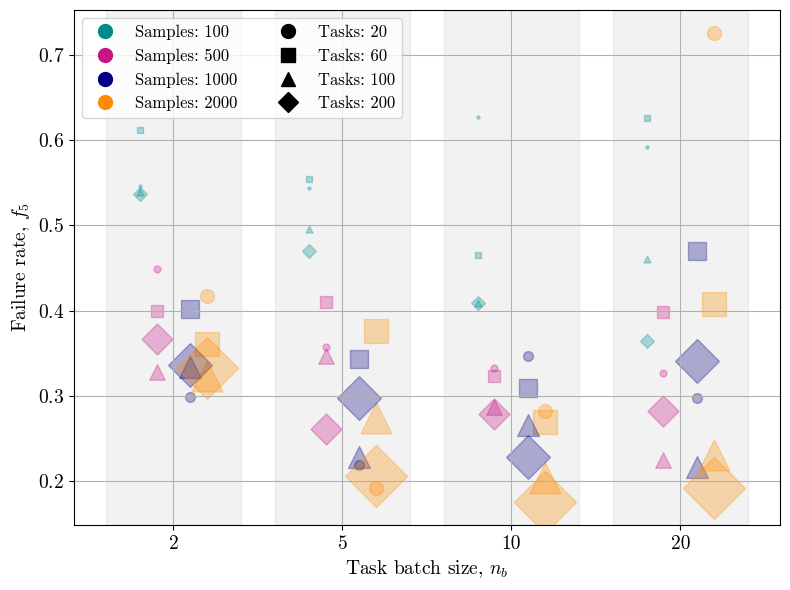

In [38]:
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

# Define distinct colors for the number of samples
sample_colors = {
    100: 'darkcyan',
    500: 'mediumvioletred',
    1000: 'navy',
    2000: 'darkorange'
}

offsets = {
    100: -0.2,
    500: -0.1,
    1000: 0.1,
    2000: 0.2
}

# Define distinct marker styles for the number of tasks
task_markers = {
    20: 'o',    # Circle
    60: 's',    # Square
    100: '^',   # Triangle
    200: 'D'    # Diamond
}

# Load the data from the file
fname = 'maml_data_volume_results.h5'
with h5.File(fname, 'r') as f:
    mape_values = np.array(f['frate_values'])
    param_combinations = np.array(f['param_combinations'])

# Extract parameter values
batch_sizes = param_combinations[:, 0]  # First parameter: batch_size
n_tasks = param_combinations[:, 1]     # Second parameter: n_tasks
n_samples = param_combinations[:, 2]   # Third parameter: n_samples

# Map batch sizes to evenly spaced positions
unique_batch_sizes = sorted(set(batch_sizes))  # Get unique batch sizes
batch_size_positions = {batch_size: idx for idx, batch_size in enumerate(unique_batch_sizes)}  # Map batch sizes to integers
mapped_batch_sizes = [batch_size_positions[bs] for bs in batch_sizes]  # Map each batch size in the data

# Create the scatter plot
plt.figure(figsize=(8, 6))

# Add shaded backgrounds for each batch size
for idx in range(len(unique_batch_sizes)):
    plt.axvspan(idx - 0.4, idx + 0.4, color='gray', alpha=0.1)

for mapped_bs, batch_size, n_task, n_sample, mape in zip(mapped_batch_sizes, batch_sizes, n_tasks, n_samples, mape_values):
    plt.scatter(
        mapped_bs+offsets[n_sample], 
        mape,
        s=(n_task*n_sample)/400,
        color=sample_colors[n_sample], 
        marker=task_markers[n_task],
        alpha=0.3,
        label=f'Samples: {n_sample}, Tasks: {n_task}' if f'Samples: {n_sample}, Tasks: {n_task}' not in plt.gca().get_legend_handles_labels()[1] else None
    )

# Set axis labels and title
plt.xlabel(r'Task batch size, $n_b$', fontsize=14)
plt.ylabel(r'Failure rate, $f_{5}$', fontsize=14)
#plt.title('MAPE vs Batch Size')
plt.grid(True)

# Customize the x-axis ticks
plt.xticks(fontsize=14,ticks=range(len(unique_batch_sizes)), labels=unique_batch_sizes)
plt.yticks(fontsize=14)

# Create a legend for samples and tasks
# Legend for marker colors (number of samples)
handles_colors = [plt.Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=10, label=f'Samples: {sample}') for sample, color in sample_colors.items()]
# Legend for marker styles (number of tasks)
handles_markers = [plt.Line2D([0], [0], color='black', marker=marker, linestyle='None', markersize=10, label=f'Tasks: {task}') for task, marker in task_markers.items()]
plt.legend(fontsize=12,handles=handles_colors + handles_markers, loc='best', ncol=2)

# Show the plot
plt.tight_layout()
# plt.show()
plt.savefig('data_volume_frate.pdf', bbox_inches='tight', dpi=300)

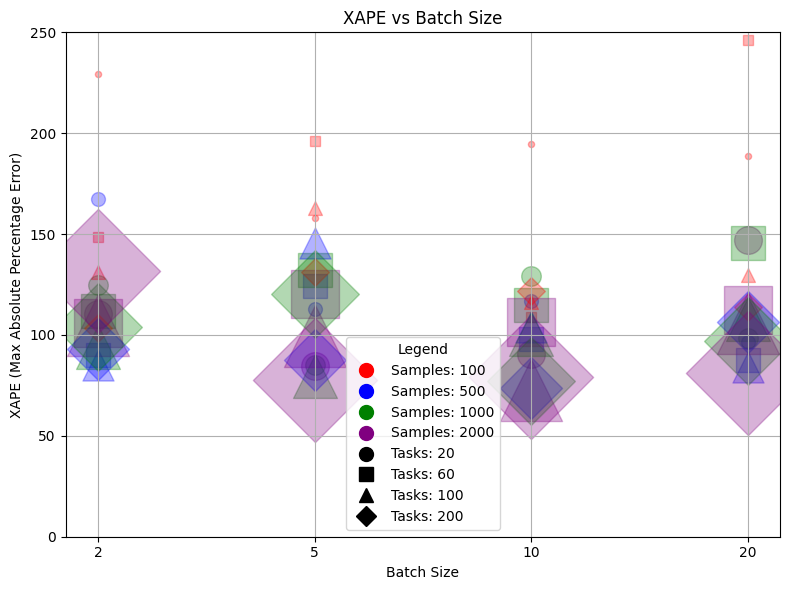

In [36]:
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np

# Define distinct colors for the number of samples
sample_colors = {
    100: 'red',
    500: 'blue',
    1000: 'green',
    2000: 'purple'
}

# Define distinct marker styles for the number of tasks
task_markers = {
    20: 'o',    # Circle
    60: 's',    # Square
    100: '^',   # Triangle
    200: 'D'    # Diamond
}

# Load the data from the file
fname = 'maml_data_volume_results.h5'
with h5.File(fname, 'r') as f:
    xape_values = np.array(f['xape_values'])
    param_combinations = np.array(f['param_combinations'])

# Extract parameter values
batch_sizes = param_combinations[:, 0]  # First parameter: batch_size
n_tasks = param_combinations[:, 1]     # Second parameter: n_tasks
n_samples = param_combinations[:, 2]   # Third parameter: n_samples

# Map batch sizes to evenly spaced positions
unique_batch_sizes = sorted(set(batch_sizes))  # Get unique batch sizes
batch_size_positions = {batch_size: idx for idx, batch_size in enumerate(unique_batch_sizes)}  # Map batch sizes to integers
mapped_batch_sizes = [batch_size_positions[bs] for bs in batch_sizes]  # Map each batch size in the data

# Create the scatter plot
plt.figure(figsize=(8, 6))
for mapped_bs, batch_size, n_task, n_sample, xape in zip(mapped_batch_sizes, batch_sizes, n_tasks, n_samples, xape_values):
    plt.scatter(
        mapped_bs, 
        xape,
        s=(n_task*n_sample)/100,
        color=sample_colors[n_sample], 
        marker=task_markers[n_task],
        alpha=0.3,
        label=f'Samples: {n_sample}, Tasks: {n_task}' if f'Samples: {n_sample}, Tasks: {n_task}' not in plt.gca().get_legend_handles_labels()[1] else None
    )

# Set axis labels and title
plt.xlabel('Batch Size')
plt.ylabel('XAPE (Max Absolute Percentage Error)')
plt.title('XAPE vs Batch Size')
plt.grid(True)
plt.ylim(0, 250)

# Customize the x-axis ticks
plt.xticks(ticks=range(len(unique_batch_sizes)), labels=unique_batch_sizes)

# Create a legend for samples and tasks
# Legend for marker colors (number of samples)
handles_colors = [plt.Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=10, label=f'Samples: {sample}') for sample, color in sample_colors.items()]
# Legend for marker styles (number of tasks)
handles_markers = [plt.Line2D([0], [0], color='black', marker=marker, linestyle='None', markersize=10, label=f'Tasks: {task}') for task, marker in task_markers.items()]
plt.legend(handles=handles_colors + handles_markers, loc='best', title='Legend')

# Show the plot
plt.tight_layout()
plt.show()